In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class Linear():
    def __init__(self, in_dim, out_dim):
        '''
        Args:
        - in_dim (int)
        - out_dim (int)
        '''
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weights = np.random.randn(in_dim, out_dim)
        self.bias = np.random.randn(out_dim)
        
    def __call__(self, x):
        '''
        Args:
        - x (numpy.array[batch, in_dim])
        
        Returns:
        - (numpy.array[batch, out_dim])
        '''
        return np.matmul(x, self.weights) + self.bias[np.newaxis, ...]
    

class ReLU():
    def __init__(self):
        pass
    
    def __call__(self, x):
        '''
        Args:
        - x (numpy.array[arbitrary size])
        
        Returns:
        - (numpy.array[arbitrary size])
        '''
        return (x > 0) * x
    
class Softmax():
    def __init__(self):
        pass
    
    def __call__(self, x):
        '''
        Args:
        - x (numpy.array[arbitrary size])
        
        Returns:
        - (numpy.array[arbitrary size])
        '''
        return np.exp(x) / np.exp(x).sum(1)[..., np.newaxis]

In [3]:
def compute_loss(logits, labels):
    '''
    Args:
    - logits (numpy.array[batch, out_dim])
    - labels (numpy.array[batch,])
    
    Returns:
    - (int): Loss
    '''
    probs = np.exp(logits) / np.exp(logits).sum(1)[..., np.newaxis]  # softmax output
    target_probs = probs[np.arange(labels.shape[0])[..., np.newaxis], labels[..., np.newaxis]][:, 0]
    loss = -np.log(target_probs).sum()  # cross-entropy loss
    return loss

def compute_prediction(logits):
    '''
    Args:
    - logits (numpy.array[batch, out_dim])
    
    Returns:
    - (numpy.array[batch, ]): class predictions
    '''
    return np.argmax(logits, axis=1)

def compute_accuracy(prediction, labels):
    '''
    Args:
    - prediction (numpy.array[batch, ])
    - labels (numpy.array[batch,])
    
    Returns:
    - (int): accuracy score
    '''
    return (prediction == labels).sum() / (labels.shape[0])

def to_one_hot(x):
    one_hot = np.zeros((x.shape[0], num_classes))
    one_hot[np.arange(x.shape[0])[..., np.newaxis], x[..., np.newaxis]] = 1.
    return one_hot

In [4]:
class ThreeLayersNetwork():
    def __init__(self, in_dim, n_cls):
        '''
        Args:
        - in_dim (int)
        - n_cls (int): number of class
        '''
        self.lin1 = Linear(in_dim, 64)
        self.lin2 = Linear(64, 32)
        self.lin3 = Linear(32, n_cls)
        self.relu = ReLU()
        self.softmax = Softmax()
    
    def compute_logits(self, x):
        '''
        Forward propagation
        
        Args:
        - x (numpy.array[batch, in_dim])
        
        Returns:
        - logits (numpy.array[batch, n_cls]): before softmax
        '''
        out = self.lin1(x)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.relu(out)
        out = self.lin3(out)
        return out
    
    def train(self, x, y, lr):
        '''
        Backward propagation
        
        Args:
        - x (numpy.array[batch, in_dim])
        - y (numpy.array[batch, ]): ground truth
        - lr (float/int): learning rate 
        '''
        m = y.shape[0]
        y = to_one_hot(y)
        
        # Forward
        z1 = self.lin1(x)
        a1 = self.relu(z1)
        z2 = self.lin2(a1)
        a2 = self.relu(z2)
        z3 = self.lin3(a2)
        y_pred = self.softmax(z3)
        
        # Backward (compute gradients)
        dz3 = y_pred - y
        dw3 = (1/m) * np.matmul(a2.T, dz3)  # [i, m] * [m, j] = [i, j]
        db3 = (1/m) * dz3.sum(0)
        da2 = np.matmul(dz3, self.lin3.weights.T)  # [m, j] * [j, i] = [m, i]
        dz2 = da2 * (z2 > 0)
        dw2 = (1/m) * np.matmul(a1.T, dz2)  # [i, m] * [m, j] = [i, j
        db2 = (1/m) * dz2.sum(0)
        da1 = np.matmul(dz2, self.lin2.weights.T)  # [m, j] * [j, i] = [m, i]
        dz1 = da1 * (z1 > 0)
        dw1 = (1/m) * np.matmul(x.T, dz1)  # [i, m] * [m, j] = [i, j]
        db1 = (1/m) * dz1.sum(0)
        
        # Gradient Descent (update weights)
        self.lin1.weights -= lr * dw1
        self.lin2.weights -= lr * dw2
        self.lin3.weights -= lr * dw3
        self.lin1.bias -= lr * db1
        self.lin2.bias -= lr * db2
        self.lin3.bias -= lr * db3

## Forward

In [5]:
batch_size = 20
dimension = 100
num_classes = 10
data = np.random.random([batch_size, dimension])

labels = np.random.randint(num_classes, size=[batch_size]) # labels are 0~9
network = ThreeLayersNetwork(dimension, num_classes)
logits = network.compute_logits(data) # output of the network with shape[20, 10]
loss = compute_loss(logits, labels) # compute cross-entropy loss
prediction = compute_prediction(logits) # prediction made by the model
accuracy = compute_accuracy(prediction, labels) # compute accuracy of the batch

/home/jayson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


## Backward

In [7]:
print_intv = 5
lr = 0.01
num_epochs = 300
tr_losses = []
tr_accs = []
for ep in tqdm(range(num_epochs)):
    network.train(data, labels, lr=lr)
    logits = network.compute_logits(data) # output of the network with shape[20, 10]
    loss = compute_loss(logits, labels) # compute cross-entropy loss
    prediction = compute_prediction(logits) # prediction made by the model
    accuracy = compute_accuracy(prediction, labels) # compute accuracy of the batch
    tr_losses.append(loss)
    tr_accs.append(accuracy)
    if ep % print_intv == 0:
        print(f'(Epoch {ep}/{num_epochs}) Tr Loss = {loss:.2f} | Tr Acc = {accuracy:.2f}')

  0%|          | 0/300 [00:00<?, ?it/s]

(Epoch 0/300) Tr Loss = 174.12 | Tr Acc = 0.50
(Epoch 5/300) Tr Loss = 153.71 | Tr Acc = 0.55
(Epoch 10/300) Tr Loss = 137.99 | Tr Acc = 0.65
(Epoch 15/300) Tr Loss = 125.33 | Tr Acc = 0.65
(Epoch 20/300) Tr Loss = 114.64 | Tr Acc = 0.70
(Epoch 25/300) Tr Loss = 105.15 | Tr Acc = 0.70
(Epoch 30/300) Tr Loss = 96.28 | Tr Acc = 0.70
(Epoch 35/300) Tr Loss = 88.32 | Tr Acc = 0.70
(Epoch 40/300) Tr Loss = 81.19 | Tr Acc = 0.70
(Epoch 45/300) Tr Loss = 74.57 | Tr Acc = 0.75
(Epoch 50/300) Tr Loss = 68.23 | Tr Acc = 0.75
(Epoch 55/300) Tr Loss = 62.07 | Tr Acc = 0.80
(Epoch 60/300) Tr Loss = 56.05 | Tr Acc = 0.80
(Epoch 65/300) Tr Loss = 50.12 | Tr Acc = 0.80
(Epoch 70/300) Tr Loss = 44.26 | Tr Acc = 0.80
(Epoch 75/300) Tr Loss = 38.50 | Tr Acc = 0.80
(Epoch 80/300) Tr Loss = 32.81 | Tr Acc = 0.80
(Epoch 85/300) Tr Loss = 27.29 | Tr Acc = 0.80
(Epoch 90/300) Tr Loss = 22.21 | Tr Acc = 0.80
(Epoch 95/300) Tr Loss = 18.12 | Tr Acc = 0.85
(Epoch 100/300) Tr Loss = 14.89 | Tr Acc = 0.90
(Epoch 1

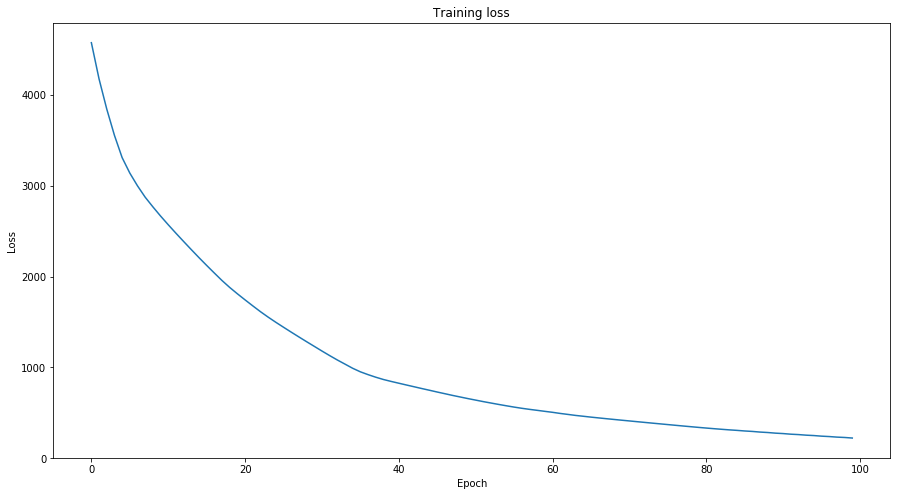

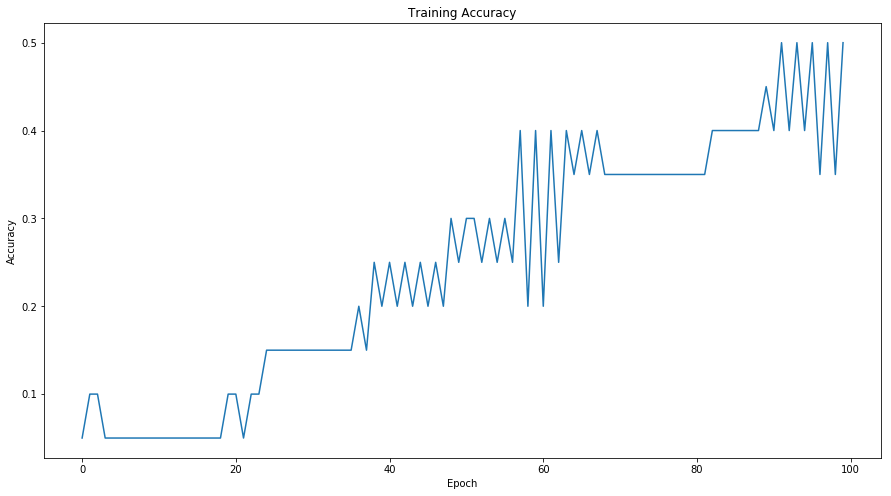

In [9]:
plt.figure(figsize=(15,8))
plt.plot(tr_losses)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(tr_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()